In [1]:
import pandas as pd
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import circlify as circ
import matplotlib.patches as pltp
from tqdm import tqdm

count_plot_limit = 50

sys.path.append('../')

from src import CLEAN_PATENTS_PATH, CITATIONS_PATH
from src import TEXT_EMBEDDING_PATH
from src.data import PatentsDataset
from src.models.similarities import *

INFO:transformers.file_utils:PyTorch version 1.4.0 available.


In [2]:
patents = PatentsDataset(CLEAN_PATENTS_PATH, 
                         ipc_tags_format='list', 
                         clean_df=False, 
                         path_to_citations=CITATIONS_PATH, 
                         join_citations=False)

INFO:root:Start reading data.
INFO:root:Read /Users/valik/LMU/patent-similarity-siemens/data/patents-clean.csv. Number of patents: 6,881,033.
INFO:root:Skip cleaning.
INFO:root:Start reading citations.
INFO:root:Read /Users/valik/LMU/patent-similarity-siemens/data/citations-only-type-x.csv. Number of citations: 6,041,402.
INFO:root:Start creating undirected citations graph.
INFO:root:Citations graph created. Number of edges: 6,041,398. Number of nodes: 6,882,086


### Basic statistics

In [3]:
positeves_per_query = patents.citations.groupby('pub_number')['cit_number'].count()

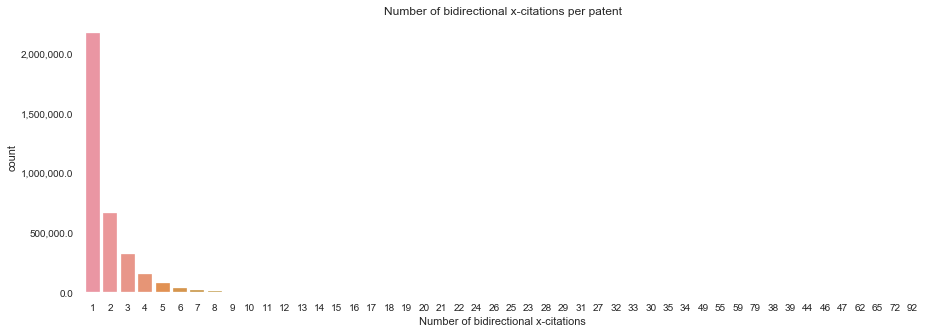

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.countplot(positeves_per_query.values, order = positeves_per_query.value_counts().iloc[:count_plot_limit].index)
plt.xlabel('Number of bidirectional x-citations')
plt.title('Number of bidirectional x-citations per patent')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,}"))
plt.savefig('../reports/figures/bider_x_citations_count.png', dpi = 300)

In [5]:
positeves_per_query.describe().apply("{0:4f}".format)

count    3461282.000000
mean           1.745423
std            1.345135
min            1.000000
25%            1.000000
50%            1.000000
75%            2.000000
max           92.000000
Name: cit_number, dtype: object

### X-citation graph statistics

In [3]:
# Dropping cycles in directed graph
cycles = patents.citations.merge(patents.citations, left_on='cit_number', right_on='pub_number')
cycles = cycles[cycles.pub_number_x == cycles.cit_number_y]
cycles = cycles[['pub_number_x', 'cit_number_x']]
cycles.values.sort()
cycles = cycles.drop_duplicates()
cycles = cycles.rename(columns={'pub_number_x': 'pub_number', 'cit_number_x':'cit_number'})
patents.citations = patents.citations[~patents.citations.pub_number.isin(cycles.pub_number) &
                                      ~patents.citations.cit_number.isin(cycles.cit_number)]
patents.citations

pub_number        cit_number
0           EP-3439050-A3  US-2014332839-A1
1           EP-3439050-A3  KR-20140092038-A
2           EP-3439050-A3  US-2012025242-A1
3           EP-3439041-A3  US-2014103400-A1
4           EP-3447209-A1      GB-2391577-A
5           EP-3447209-A1      GB-1423651-A
6           EP-3447209-A1      GB-1171693-A
7           EP-3441049-A3  US-2012083772-A1
8           EP-3441049-A3  US-2010057060-A1
9           EP-3441049-A3  US-2009192437-A1
10          EP-3441049-A3    DE-10323422-A1
11          EP-3444751-A3     WO-9843042-A1
12       WO-2019036047-A1  WO-2015184450-A1
13       WO-2019034794-A1  KR-20130109300-A
14       WO-2019036047-A1  US-2013178891-A1
15       WO-2019034794-A1   JP-2012224665-A
16       WO-2019035151-A1  WO-2012033863-A1
17       WO-2019036702-A1  US-2012027399-A1
18       WO-2019034794-A1   JP-2010173169-A
19       WO-2019036696-A1  US-2007071695-A1
20       WO-2019036696-A1  US-2007071696-A1
21       WO-2019035151-A1  US-2006246403-A1
22       WO-2019036697-A1  US-2004113890-A1
23       WO-2019036047-A1  US-2002138094-A1
24       WO-2019034794-A1   JP-2002052562-A
25       WO-2019036047-A1  US-2002002383-A1
26       WO-2019036047-A1     WO-0167989-A2
27       WO-2019034794-A1    JP-H08207046-A
28       WO-2019035994-A1  WO-2017019837-A1
29       WO-2019034888-A1  WO-2016203140-A1
...                   ...               ...
6041372      GB-1457966-A   JP-2002277354-A
6041373      NL-7503050-A      GB-1107969-A
6041374     FR-2249575-A5      US-3563347-A
6041375     FR-2249575-A5      GB-1138625-A
6041376     FR-2249575-A5       GB-929179-A
6041377     FR-2225965-A5       GB-378127-A
6041378     FR-2197392-A5       GB-312464-A
6041379     FR-2178461-A5      GB-1128793-A
6041380     FR-2172496-A5     FR-2048344-A5
6041381     FR-2127456-A5      GB-1031925-A
6041382     FR-2123904-A6      GB-1132645-A
6041383     FR-2087202-A5      GB-1163979-A
6041384     FR-2058171-A1       GB-847496-A
6041385     FR-2008417-A1       GB-893273-A
6041386      GB-1133334-A  US-2008284552-A1
6041387      GB-1133334-A  US-2001030591-A1
6041388      GB-1133334-A      US-6144269-A
6041389      GB-1133334-A      US-5884990-A
6041390      GB-1133334-A      US-4969032-A
6041391       GB-839068-A  US-2008243336-A1
6041392       GB-839068-A      GB-2348405-A
6041393       GB-839068-A      GB-2346592-A
6041394       GB-839068-A      US-5593176-A
6041395       GB-425800-A  US-2013152646-A1
6041396       GB-425800-A  WO-2013044905-A1
6041397       GB-425800-A     EP-2476824-A2
6041398       GB-425800-A     FR-2808552-A1
6041399       GB-425800-A    DE-19639545-C1
6041400       GB-425800-A      US-4807454-A
6041401       GB-425800-A      US-4712398-A

[6041396 rows x 2 columns]

In [4]:
from networkx.algorithms.components.connected import number_connected_components
from networkx.algorithms.dag import dag_longest_path_length, is_directed_acyclic_graph, transitive_closure
from networkx.algorithms.cycles import simple_cycles

In [5]:
G = nx.from_pandas_edgelist(patents.citations, source='pub_number', target='cit_number', create_using=nx.DiGraph)
G_closure = transitive_closure(G)
G_undirected = G.to_undirected()

In [6]:
print('X-citation graph statistics')
print(f'Number of edges: {len(G.edges):,}')
print(f'Number of edges in closure: {len(G_closure.edges):,}')
print(f'Number of nodes: {len(G.nodes):,}')
print(f'Number connected components: {number_connected_components(G_undirected):,}')
print(f'Longest path length: {dag_longest_path_length(G)}')

X-citation graph statistics
Number of edges: 6,041,396
Number of edges in closure: 8,144,287
Number of nodes: 6,882,085
Number connected components: 1,491,554
Longest path length: 10


### Connected components

In [11]:
connected_components_lenghts = [len(c) for c in nx.connected_components(G_undirected)]
connected_components_lenghts = pd.Series(connected_components_lenghts)

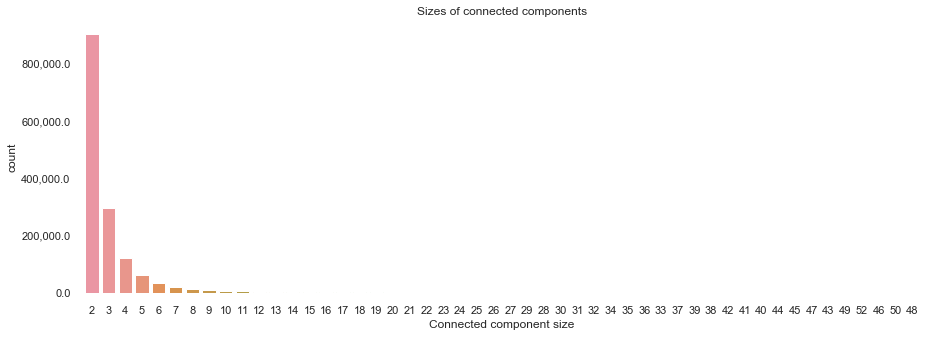

In [91]:
count_plot_limit = 50
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.countplot(connected_components_lenghts, 
              order = connected_components_lenghts.value_counts().iloc[:count_plot_limit].index)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,}"))
sns.despine(left=True, bottom=True)
plt.xlabel('Connected component size')
plt.title('Sizes of connected components')
plt.savefig('../reports/figures/connected_comp_sizes_count.png', dpi = 300)

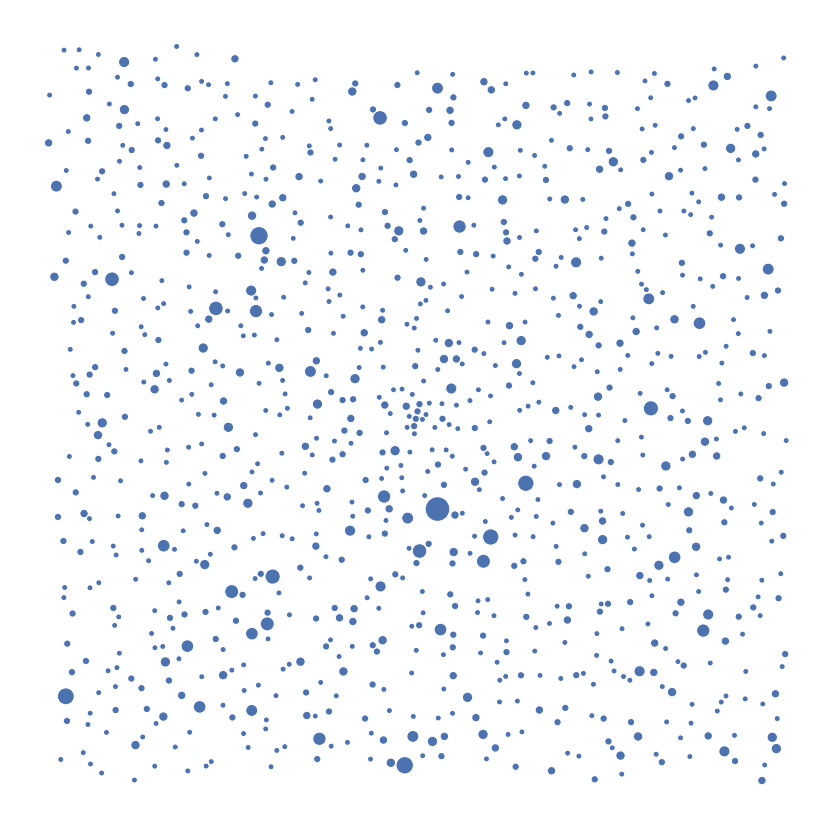

In [134]:
data = connected_components_lenghts[connected_components_lenghts < connected_components_lenghts.quantile(0.9999)].sample(1000)

class C():
    def __init__(self,r):
        self.N = len(r)
        self.x = np.ones((self.N,3))
        self.x[:,2] = r
        maxstep = 2*self.x[:,2].max()
        length = np.ceil(np.sqrt(self.N))
        grid = np.arange(0,length*maxstep,maxstep)
        gx,gy = np.meshgrid(grid,grid)
        self.x[:,0] = gx.flatten()[:self.N]
        self.x[:,1] = gy.flatten()[:self.N]
        self.x[:,:2] = self.x[:,:2] - np.mean(self.x[:,:2], axis=0)

        self.step = self.x[:,2].min()
        self.p = lambda x,y: np.sum((x**2+y**2)**2)
        self.E = self.energy()
        self.iter = 1.

    def minimize(self):
        while self.iter < 7:
            for i in range(self.N):
                rand = np.random.randn(2)*self.step/self.iter
                self.x[i,:2] += rand
                e = self.energy()
                if (e < self.E and self.isvalid(i)):
                    self.E = e
                    self.iter = 1.
                else:
                    self.x[i,:2] -= rand
                    self.iter += 1.

    def energy(self):
        return self.p(self.x[:,0], self.x[:,1])

    def distance(self,x1,x2):
        return np.sqrt((x1[0]-x2[0])**2+(x1[1]-x2[1])**2)-x1[2]-x2[2]

    def isvalid(self, i):
        for j in range(self.N):
            if i!=j: 
                if self.distance(self.x[i,:], self.x[j,:]) < 0:
                    return False
        return True

    def plot(self, ax):
        for i in range(self.N):
            circ = plt.Circle(self.x[i,:2],self.x[i,2] )
            ax.add_patch(circ)

c = C(np.sqrt(data))

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"), figsize=(15, 15))
ax.axis("off")
c.minimize()
c.plot(ax)
ax.relim()
ax.autoscale_view()
plt.savefig('../reports/figures/connected_comp.png', dpi = 300)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
nx.draw(G, with_labels=False, node_size=25, edge_color='Black')

## X-citations and time

In [3]:
# present_citations = patents.citations[patents.citations.pub_number.isin(patents.patents.pub_number) & \
#                                       patents.citations.cit_number.isin(patents.patents.pub_number)]
present_citations = patents.citations

In [4]:
citing_patents = pd.merge(present_citations, patents.patents, left_on='pub_number', right_on='pub_number')
cited_patents = pd.merge(present_citations, patents.patents, left_on='cit_number', right_on='pub_number')

Text(0, 0.5, 'Number of patents')

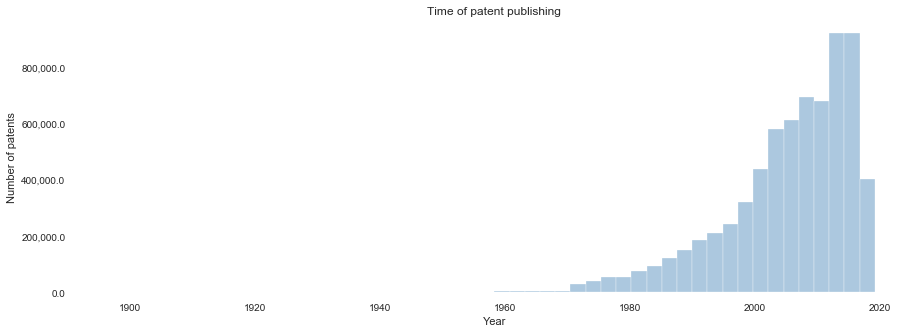

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
patents.patents.date.hist(bins=50, color=(172/255, 200/255, 223/255))
ax.grid(False)
sns.despine(left=True, bottom=True)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,}"))
plt.title('Time of patent publishing')
plt.xlabel('Year')
plt.ylabel('Number of patents')

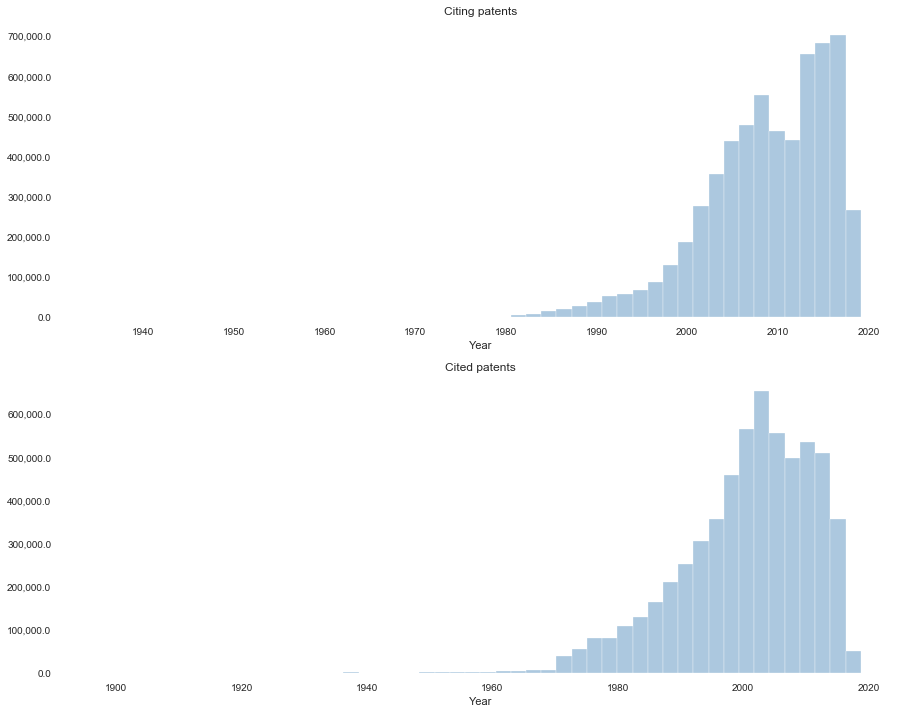

In [6]:
fig, ax = plt.subplots(2, 1, figsize = (15, 12))

citing_patents.date.hist(ax=ax[0], bins=50, color=(172/255, 200/255, 223/255))
ax[0].set_title('Citing patents')
ax[0].set_xlabel('Year')
ax[0].grid(False)
ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,}"))

cited_patents.date.hist(ax=ax[1], bins=50, color=(172/255, 200/255, 223/255))
ax[1].set_title('Cited patents')
ax[1].set_xlabel('Year')
ax[1].grid(False)
ax[1].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,}"))
sns.despine(left=True, bottom=True)

In [7]:
cross_df = pd.merge(citing_patents, cited_patents, left_on='cit_number', right_on='cit_number')

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


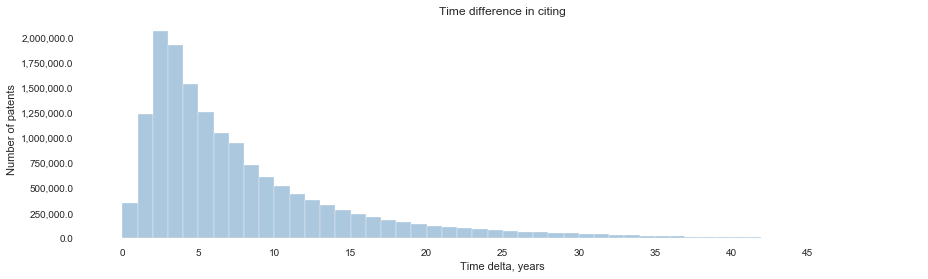

In [8]:
time_deltas = (((cross_df.date_x - cross_df.date_y).astype('timedelta64[s]')/(60*60*24*365)))
fig, ax = plt.subplots(1, 1, figsize = (15, 4))
time_deltas.hist(range=(0.0, 50), bins=50, color=(172/255, 200/255, 223/255))
# sns.distplot()
ax.grid(False)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,}"))
sns.despine(left=True, bottom=True)
plt.title('Time difference in citing')
plt.xlabel('Time delta, years')
plt.ylabel('Number of patents')
plt.xticks(np.arange(0, 50, 5))
plt.savefig('../reports/figures/citing_time_delta.png', dpi = 300)